# The Perils in Tahiti
In our game of Seafall the 3rd island is named Tahiti. It has a crucial caveat when attempting endeavors on this island, "Reroll all minor successes rolled during endeavors here." On first thought, this doesn't sound too bad. Minor successes are only a single face on each die, but just how risky is it to step foot on this island?

In [1]:
%matplotlib inline

import itertools
import matplotlib
import matplotlib.pyplot
import numpy
import os
import pandas
import scipy.misc
import scipy.special
import seaborn

In [2]:
# colormap for data visualizations
cmap = seaborn.cubehelix_palette(n_colors = 20, start = 0.8, rot = 0.75,
                                gamma = 0.3, hue = 2.0, dark = 0.005,
                                light = 0.95, reverse = True, as_cmap = True)

# Redefine the probability of rolling a blank
Without any modifications the chance of rolling a blank is $1/3$ and the chance of rolling a minor success is $1/6$. Now, we must account for the situation where every minor success is re-rolled. Again there is a $1/3$ of rolling a blank, but we might end up with additional rolls if another minor success turns up. Conceivably, an infinite sequence of rolling could occur if a minor success is repeatedly rolled over and over again. To calculate the chances of rolling a blank than requires us to write an equation that is infinitely long.

$$\frac{1}{3} + \frac{1}{6} \left(  \frac{1}{3} + \frac{1}{6} \left( \frac{1}{3} + \frac{1}{6} \left( \frac{1}{3} + \cdots \right.\right.\right.$$

Beginning to perform the mulitplication reveals a series,

$$\frac{1}{3} + \frac{1}{3} \cdot \frac{1}{6} + \frac{1}{3} \cdot \frac{1}{6 \cdot 6} + \frac{1}{3} \cdot \frac{1}{6 \cdot 6 \cdot 6} + \cdots$$

Conveniently, this is a geometric series, which converges to a known formula.

$$ \frac{1}{3} \sum_{k=0}^\infty \left(\frac{1}{6}\right)^k \Rightarrow \frac{1}{3} \cdot \frac{1}{1 - \frac{1}{6}} = 0.4$$


In [3]:
p_success = 0.6

def prob_success(num_success, total_dice):
    if total_dice < num_success:
        p = 0.0
    else:
        p = (p_success)**num_success * \
        (1-p_success)**(total_dice-num_success) * \
        scipy.misc.comb(total_dice, total_dice - num_success)
    return p

def prob_success_or_better(num_success, total_dice):
    if total_dice < num_success:
        p = 0.0
    else:
        rng_success = numpy.arange(num_success, total_dice + 1)
        array_success = [prob_success(n, total_dice) for n in rng_success]
        p = numpy.sum(array_success)
    return p

In [4]:
row_success = numpy.arange(1,16) # number of dice showing the success face
col_dice = numpy.arange(1,16) # number of dice in the pool
sdp = numpy.zeros((numpy.size(row_success),numpy.size(col_dice)))
prob = [prob_success_or_better(*i) for i in itertools.product(row_success, col_dice)]
ind = [tuple(numpy.subtract(i,1)) for i in itertools.product(row_success, col_dice)]
for idx, val in enumerate(ind):
    sdp[val] = prob[idx]
sdp_dataframe = pandas.DataFrame(data = sdp, index = row_success, columns = col_dice)
sdp_dataframe_stack = sdp_dataframe.stack().reset_index().rename(
    columns = {
        "level_0" : "number_success", 
        "level_1" : "number_dice_pool", 
        0 : "probability_GTE_to_number_success"})

sdp_pivot = sdp_dataframe_stack.pivot("number_dice_pool", 
                                      "number_success", 
                                      "probability_GTE_to_number_success")

sdp_mask = numpy.logical_or(sdp_pivot > 0.999, numpy.triu(numpy.ones((15,15)), 1))

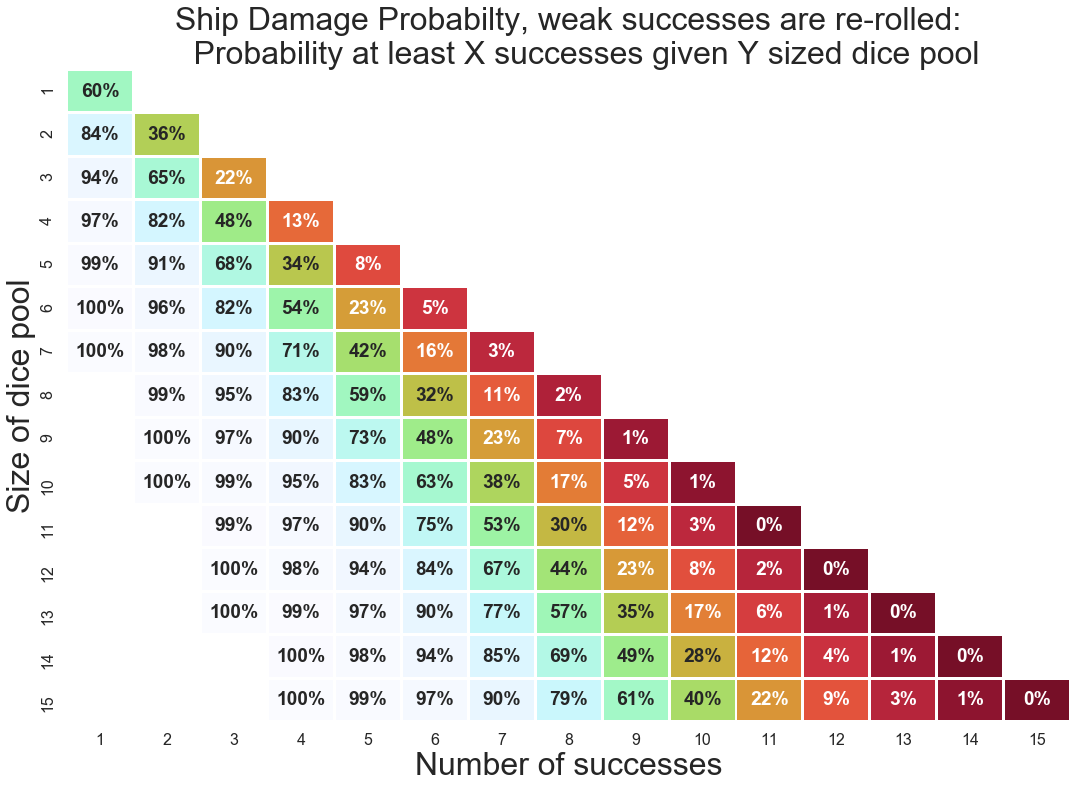

In [5]:
seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(18, 12))
ax = seaborn.heatmap(sdp_pivot, annot = True, cmap = cmap,
                     cbar = False, mask = sdp_mask, annot_kws = {"weight" : "extra bold"},
                     fmt = ".0%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)
ax.set_title(
    """Ship Damage Probabilty, weak successes are re-rolled:
    Probability at least X successes given Y sized dice pool""",
    fontsize=32)
ax.set_xlabel("Number of successes", fontsize=32)
ax.set_ylabel("Size of dice pool", fontsize=32)
fig = ax.get_figure()
fig.savefig(os.path.join("charts","ship_damage_probabilities_1to15_rerollweak.pdf"))
fig.savefig(os.path.join("charts","ship_damage_probabilities_1to15_rerollweak.svg"), format="svg", dpi=1200)

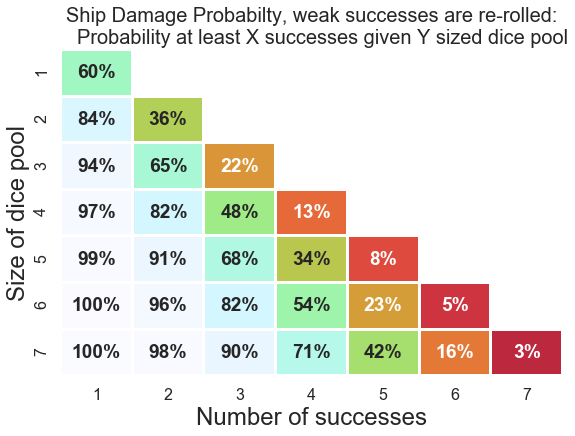

In [6]:
seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(9, 6))
sdp_dataframe_7 = sdp_dataframe_stack.loc[(sdp_dataframe_stack["number_success"] < 8) &
                                          (sdp_dataframe_stack["number_dice_pool"] < 8)]

sdp_pivot_7 = sdp_dataframe_7.pivot("number_dice_pool", 
                                    "number_success", 
                                    "probability_GTE_to_number_success")

sdp_mask_7 = numpy.logical_or(sdp_pivot_7 > 0.999, numpy.triu(numpy.ones((7,7)), 1))

ax2 = seaborn.heatmap(sdp_pivot_7, annot = True, cmap = cmap,
                     cbar = False, mask = sdp_mask_7, annot_kws = {"weight" : "extra bold"},
                     fmt = ".0%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)

ax2.set_title(
    """Ship Damage Probabilty, weak successes are re-rolled:
    Probability at least X successes given Y sized dice pool""",
    fontsize=20)
ax2.set_xlabel("Number of successes", fontsize=24)
ax2.set_ylabel("Size of dice pool", fontsize=24)
fig = ax2.get_figure()
fig.savefig(os.path.join("charts","ship_damage_probabilities_1to7_rerollweak.pdf"))
fig.savefig(os.path.join("charts","ship_damage_probabilities_1to7_rerollweak.svg"), format="svg", dpi=1200)

# At what cost?
The increase in probability from $0.\overline{3}$ to $0.4$ is enough to warrant a second thought before choosing to roll the dice. Some rolls become considerably less favorable. Consider rolling 4 dice and weighing the odds of 2 or more blanks. On a normal island this would happen $40.7\%$ of the time, but still favors success. On Tahiti the tables turn and the odds become worse than a coin toss, $52.5\%$.

# Macy's Paradise Lost
An island our group named Macy's Paradise negates minor successes, turning them into blanks. Rolling dice becomes a coin toss. This is a stronger rolling penalty than re-rolling minor successes.

In [7]:
p_success = 0.5

def prob_success(num_success, total_dice):
    if total_dice < num_success:
        p = 0.0
    else:
        p = (p_success)**num_success * \
        (1-p_success)**(total_dice-num_success) * \
        scipy.misc.comb(total_dice, total_dice - num_success)
    return p

def prob_success_or_better(num_success, total_dice):
    if total_dice < num_success:
        p = 0.0
    else:
        rng_success = numpy.arange(num_success, total_dice + 1)
        array_success = [prob_success(n, total_dice) for n in rng_success]
        p = numpy.sum(array_success)
    return p

In [8]:
row_success = numpy.arange(1,16) # number of dice showing the success face
col_dice = numpy.arange(1,16) # number of dice in the pool
sdp = numpy.zeros((numpy.size(row_success),numpy.size(col_dice)))
prob = [prob_success_or_better(*i) for i in itertools.product(row_success, col_dice)]
ind = [tuple(numpy.subtract(i,1)) for i in itertools.product(row_success, col_dice)]
for idx, val in enumerate(ind):
    sdp[val] = prob[idx]
sdp_dataframe = pandas.DataFrame(data = sdp, index = row_success, columns = col_dice)
sdp_dataframe_stack = sdp_dataframe.stack().reset_index().rename(
    columns = {
        "level_0" : "number_success", 
        "level_1" : "number_dice_pool", 
        0 : "probability_GTE_to_number_success"})

sdp_pivot = sdp_dataframe_stack.pivot("number_dice_pool", 
                                      "number_success", 
                                      "probability_GTE_to_number_success")

sdp_mask = numpy.logical_or(sdp_pivot > 0.999, numpy.triu(numpy.ones((15,15)), 1))

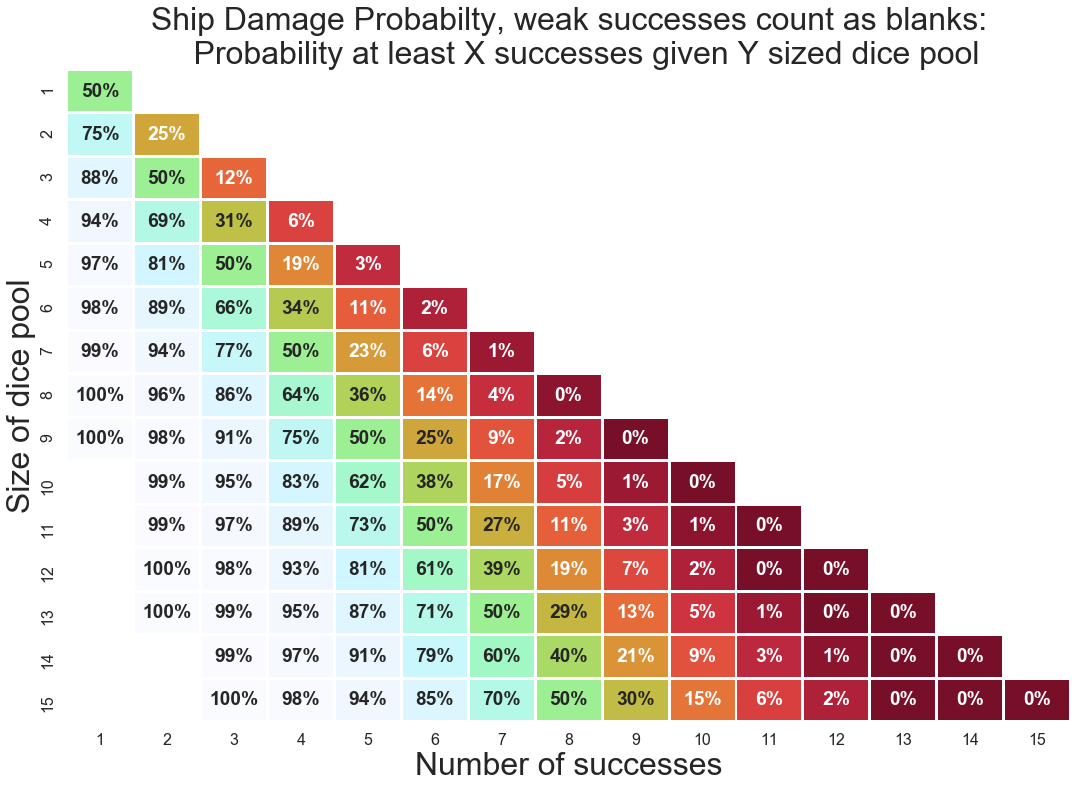

In [9]:
seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(18, 12))
ax = seaborn.heatmap(sdp_pivot, annot = True, cmap = cmap,
                     cbar = False, mask = sdp_mask, annot_kws = {"weight" : "extra bold"},
                     fmt = ".0%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)
ax.set_title(
    """Ship Damage Probabilty, weak successes count as blanks:
    Probability at least X successes given Y sized dice pool""",
    fontsize=32)
ax.set_xlabel("Number of successes", fontsize=32)
ax.set_ylabel("Size of dice pool", fontsize=32)
fig = ax.get_figure()
fig.savefig(os.path.join("charts","ship_damage_probabilities_1to15_weakasblank.pdf"))
fig.savefig(os.path.join("charts","ship_damage_probabilities_1to15_weakasblank.svg"), format="svg", dpi=1200)